In [2]:
import sys
import numpy as np
import pandas as pd
import torch
import pickle
import random
import math
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split

import torch.autograd as autograd
import torch
from torch import nn, optim
from torch.nn import functional as F

class TS(nn.Module):
    """
    Code modified from original https://github.com/gpleiss/temperature_scaling/
    """
    def __init__(self, init_t=1.5):
        super().__init__()
        self.temperature = autograd.Variable(torch.ones(1)*init_t, requires_grad=True)  
        
    def find_best_T(self, logits, labels, lr=0.01, max_iter=50):      
        optimizer = optim.LBFGS([self.temperature], lr=lr, max_iter=max_iter)
        nll_criterion = nn.CrossEntropyLoss()
               
        def eval():
            L = logits/self.temperature.unsqueeze(1)
            loss = nll_criterion(L, labels)
            loss = loss
            loss.backward(retain_graph=True)
            return loss
        optimizer.step(eval)
        
        return self.temperature.item()

class ECELoss(nn.Module):
    """
    Code from https://github.com/gpleiss/temperature_scaling/
    
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super().__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

def get_ece_loss(logits, labels):
    return ECELoss()(logits, labels).item()
    
def get_nll_loss(logits, labels):
    return nn.CrossEntropyLoss()(logits, labels).item()
    
def get_losses(loss_function, logits, labels, from_temp, to_temp, n):
    temp_space = np.linspace(from_temp,to_temp,n)
    losses = np.array([loss_function(logits/temp, labels) for temp in temp_space])
    return temp_space, losses

def get_ece_losses(logits, labels, from_temp, to_temp, n):
    return get_losses(get_ece_loss, logits, labels, from_temp, to_temp, n)

def get_nll_losses(logits, labels, from_temp, to_temp, n):
    return get_losses(get_nll_loss, logits, labels, from_temp, to_temp, n)

def print_nlls_eces(logits, temp_ts, temp_bopt, labels):
    nll_unc = get_nll_loss(logits, labels)
    nll_ts = get_nll_loss(logits/temp_ts, labels)
    nll_bopt = get_nll_loss(logits/temp_bopt, labels)

    ece_unc = get_ece_loss(logits, labels)
    ece_ts = get_ece_loss(logits/temp_ts, labels)
    ece_bopt = get_ece_loss(logits/temp_bopt, labels)
    
    print(f'+-----+---------+---------+---------+')
    print(f'|     | Before  |    TS   |   BOPT  |')
    print(f'+-----+---------+---------+---------+')
    print(f'| NLL | {nll_unc:7.5f} | {nll_ts:6.5f} | {nll_bopt:6.5f} |')
    print(f'| ECE | {ece_unc:7.5f} | {ece_ts:6.5f} | {ece_bopt:6.5f} |')
    print(f'+-----+---------+---------+---------+')

def compute_accuracy(y_true, y_pred):
    acc = []
    for i in range(7):
        current_pred = y_pred[y_true == i]
        acc.append((current_pred == i).sum().item()/current_pred.shape[0])
    print("acc (%) | " + " | ".join([f'{f*100:5.2f}' for f in acc]) + " | " + f'{100*(y_pred == y_true).sum().item()/len(y_true):5.2f}')    
    return acc

### Loading logits

In [4]:
# densenet201, resnet152
model_name = 'resnet152'

logits_full, labels_full = torch.load(f'logits/isic_{model_name}_logits')

idxs_valid, idxs_test = train_test_split(list(range(logits_full.shape[0])), test_size=0.8, random_state=42, stratify=labels_full)
logits_valid = logits_full[idxs_valid]
labels_valid = labels_full[idxs_valid]
logits_test = logits_full[idxs_test]
labels_test = labels_full[idxs_test]

pred_test = F.softmax(logits_test, dim=1).argmax(dim=1)
pred_valid = F.softmax(logits_valid, dim=1).argmax(dim=1)

print("validation")
acc_valid = compute_accuracy(labels_valid, pred_valid)
print("test")
acc_test = compute_accuracy(labels_test, pred_test)

validation
acc (%) | 74.16 | 95.52 | 87.80 | 61.54 | 61.36 | 55.56 | 91.67 | 87.39
test
acc (%) | 64.89 | 96.60 | 86.59 | 75.24 | 68.18 | 72.97 | 93.33 | 88.42


In [5]:
# split valid even further
idxs_valid_curr, _ = train_test_split(idxs_valid, test_size=0.9, random_state=42, stratify=labels_full[idxs_valid])
logits_valid = logits_full[idxs_valid_curr]
labels_valid = labels_full[idxs_valid_curr]

### MulticlassCrossEntropyLoss or Negative Log Likelihood (NLL) and Expected Calibration Error (ECE)

In [6]:
temperature = 2.5
logits_scaled = logits_valid/temperature
nn.CrossEntropyLoss()(logits_scaled, labels_valid), ECELoss()(logits_scaled, labels_valid)

(tensor(0.2304), tensor([0.0652]))

validation_size = 80


<IPython.core.display.Javascript object>


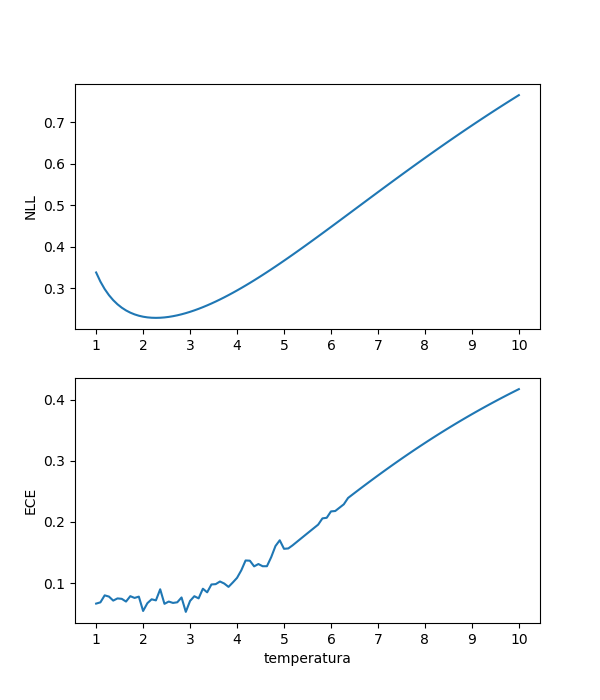

In [7]:
%matplotlib notebook

from_temp = 1
to_temp = 10
temp_space, nll_losses = get_nll_losses(logits_valid, labels_valid, from_temp, to_temp, 100)
temp_space, ece_losses = get_ece_losses(logits_valid, labels_valid, from_temp, to_temp, 100)

print(f"validation_size = {len(logits_valid)}")

plt.figure(figsize=(6,7))
plt.subplot(211)
plt.plot(temp_space, nll_losses)
plt.ylabel('NLL')
plt.xticks(np.arange(from_temp, to_temp+1, 1.0))

plt.subplot(212)
plt.plot(temp_space, ece_losses)
plt.xlabel('temperatura')
plt.ylabel('ECE')
x = plt.xticks(np.arange(from_temp, to_temp+1, 1.0))

### Search temperature space using Bayesian Optimization

In [8]:
def bayesian_optim(temperature):
    return 1/(get_nll_loss(logits_valid/temperature, labels_valid)+1e-6)
#     return 1/(get_ece_loss(logits_valid/temperature, labels_valid)+1e-6)

optimizer = BayesianOptimization(
    f=bayesian_optim,
    pbounds={'temperature': (1, 10)},
    random_state=42,
)

In [9]:
%%time
optimizer.maximize(n_iter=10, init_points=4)
bopt_t = optimizer.max['params']['temperature']

|   iter    |  target   | temper... |
-------------------------------------
|  1        |  3.129    |  4.371    |
|  2        |  1.364    |  9.556    |
|  3        |  1.724    |  7.588    |
|  4        |  2.083    |  6.388    |
|  5        |  2.959    |  1.0      |
|  6        |  4.236    |  2.773    |
|  7        |  4.371    |  2.258    |
|  8        |  4.351    |  2.452    |
|  9        |  4.35     |  2.098    |
|  10       |  4.371    |  2.296    |
|  11       |  4.37     |  2.24     |
|  12       |  4.371    |  2.283    |
|  13       |  4.371    |  2.254    |
|  14       |  4.371    |  2.286    |
CPU times: user 16.9 s, sys: 137 ms, total: 17 s
Wall time: 11.1 s


In [10]:
bopt_t

2.283150323640966

### Comparing TS with ATS

In [11]:
lr = 0.01
max_iter = 50
init_t = 1.5

ts = TS(init_t=init_t) 
ts_best_t = ts.find_best_T(logits_valid, labels_valid, lr=lr, max_iter=max_iter)

print("# Best T")
print(f"TS    = {ts_best_t:.3f}")
print(f"BOPT  = {bopt_t:.3f}")

print(f"# validation_size = {len(labels_valid)}")
print_nlls_eces(logits_valid, ts_best_t, bopt_t, labels_valid)
print(f"# test_size = {len(logits_test)}")
print_nlls_eces(logits_test, ts_best_t, bopt_t, labels_test)

# Best T
TS    = 7.232
BOPT  = 2.283
# validation_size = 80
+-----+---------+---------+---------+
|     | Before  |    TS   |   BOPT  |
+-----+---------+---------+---------+
| NLL | 0.33800 | 0.55070 | 0.22879 |
| ECE | 0.06650 | 0.28869 | 0.07155 |
+-----+---------+---------+---------+
# test_size = 3205
+-----+---------+---------+---------+
|     | Before  |    TS   |   BOPT  |
+-----+---------+---------+---------+
| NLL | 0.70701 | 0.59393 | 0.38951 |
| ECE | 0.08822 | 0.23649 | 0.04369 |
+-----+---------+---------+---------+


### Histograms

<IPython.core.display.Javascript object>


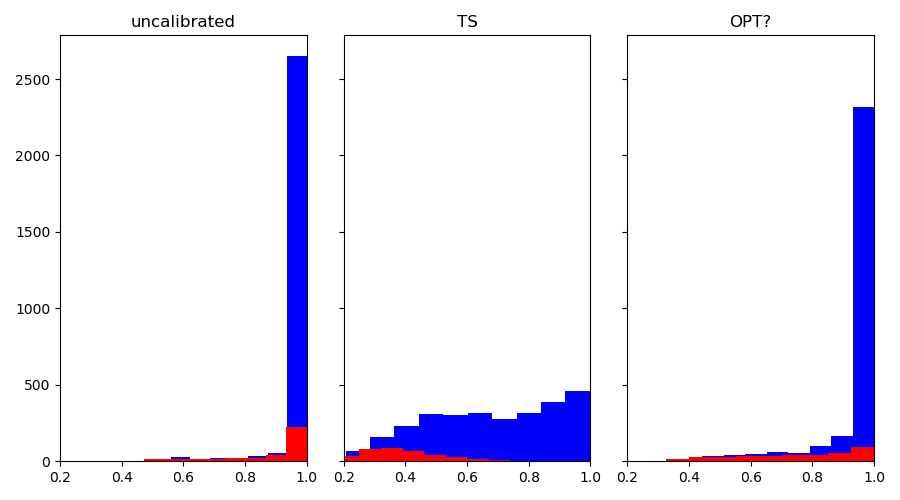

In [12]:
# Uncalibrated
softmax_unc = torch.softmax(logits_test, dim=1)
corr_ones = (labels_test == np.argmax(softmax_unc, axis=1)).numpy() == 1
softmax_unc = softmax_unc.max(dim=1)[0].numpy()

# TS
logits_test_scaled_ts = logits_test/ts_best_t
softmax_ts = torch.softmax(logits_test_scaled_ts, dim=1)
softmax_ts = softmax_ts.max(dim=1)[0].numpy()

# Bayesian Optimization
logits_test_scaled_bopt = logits_test/bopt_t
softmax_bopt = torch.softmax(logits_test_scaled_bopt, dim=1)
softmax_bopt = softmax_bopt.max(dim=1)[0].numpy()

softmax_dict = {
    'uncalibrated': softmax_unc,
    'TS': softmax_ts,
    'OPT?': softmax_bopt,
}

fig, axs = plt.subplots(1, len(softmax_dict), sharey=True, tight_layout=True, figsize=(9,5))

for i, (title, confidence) in enumerate(softmax_dict.items()):
    axs[i].hist(confidence[corr_ones == 1], color='b')
    axs[i].hist(confidence[corr_ones == 0], color='r')
    axs[i].set_title(title)
    axs[i].set_xlim([0.2, 1])
    #axs[i].set_ylim([0, 350])